In [1]:
#imports
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
#download the dataset to my machine
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

84140032/84125825 [==============================] - 62s 1us/step


In [8]:
#load the dataset
dataset_dir = ''
try:
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
except:
    dataset_dir = './aclImdb'
train_dir = os.path.join(dataset_dir, 'train')

#del a folder we dont need
try:
    remove_dir = os.path.join(train_dir, 'unsup')
    shutil.rmtree(remove_dir)
except:
    pass

#load it
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
#prepare the dataset for training
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


In [11]:
#configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#create the model

embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

In [14]:
#loss function and optimizer

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [15]:
#train the model
epochs = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/12
625/625 [==============================] - 6s 8ms/step - loss: 0.6635 - binary_accuracy: 0.6967 - val_loss: 0.6141 - val_binary_accuracy: 0.7738
Epoch 2/12
625/625 [==============================] - 3s 5ms/step - loss: 0.5484 - binary_accuracy: 0.7995 - val_loss: 0.4980 - val_binary_accuracy: 0.8222
Epoch 3/12
625/625 [==============================] - 2s 4ms/step - loss: 0.4453 - binary_accuracy: 0.8430 - val_loss: 0.4199 - val_binary_accuracy: 0.8464
Epoch 4/12
625/625 [==============================] - 3s 5ms/step - loss: 0.3784 - binary_accuracy: 0.8661 - val_loss: 0.3738 - val_binary_accuracy: 0.8598
Epoch 5/12
625/625 [==============================] - 3s 5ms/step - loss: 0.3352 - binary_accuracy: 0.8785 - val_loss: 0.3449 - val_binary_accuracy: 0.8676
Epoch 6/12
625/625 [==============================] - 3s 5ms/step - loss: 0.3044 - binary_accuracy: 0.8881 - val_loss: 0.3258 - val_binary_accuracy: 0.8720
Epoch 7/12
625/625 [==============================] - 3s 5ms/ste

In [16]:
#evaluate the model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3072 - binary_accuracy: 0.8740
Loss:  0.3072459101676941
Accuracy:  0.873960018157959


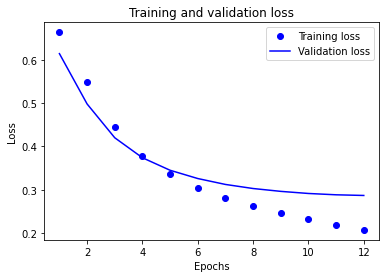

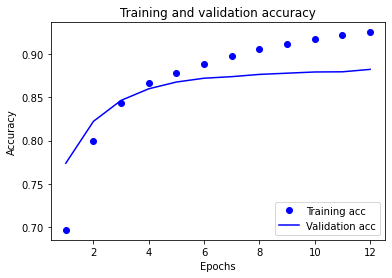

In [18]:
#change of loss and accuracy in graph
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [19]:
#make your model be capable to handle with sentences
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3072 - accuracy: 0.8740
0.873960018157959


In [24]:
#predict
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "I love you so muck!"
]

lst = export_model.predict(examples)
for i in range(len(examples)):
  print('positivity of \"'+examples[i]+'\" is: '+ str(int(lst[i]*100)) + '%')

positivity of "The movie was great!" is: 63%
positivity of "The movie was okay." is: 43%
positivity of "The movie was terrible..." is: 35%
positivity of "I love you so muck!" is: 62%
